<center><h1>SaShiMi Demo on MNIST</h1></center>

This notebook is intended to test whether our SaShiMi implementation works correctly by running it on MNIST. SaShiMi introduces new layers for down-pooling and up-pooling, which require special handling in recurrent mode.

There are unit tests available in this repository. Run all unit tests by executing the following command in the root directory:
```bash
python3 -m unittest
```

For a more preliminary introduction to S4, see [S4-MNIST-Demo](https://github.com/necrashter/SaShiMi-796/blob/master/S4-MNIST-Demo.ipynb).

# Prelude

Setup, import modules, select device, etc.

In [1]:
%matplotlib inline
# Built-in IPython extension to reload modules when updated.
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
import copy
import IPython.display as ipd

# Custom modules
from S4 import *
from sashimi import *

Using PyKeOps Cauchy kernel.


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device

device(type='cuda')

# Dataset

In [4]:
# Load datasets
MNIST_TRAIN = datasets.MNIST(root='./datasets', train=True, download=True, transform=transforms.ToTensor())
MNIST_TEST = datasets.MNIST(root='./datasets', train=False, download=True, transform=transforms.ToTensor())

dataloader = DataLoader(MNIST_TRAIN, shuffle=True, batch_size=8)
testloader = DataLoader(MNIST_TEST, shuffle=False, batch_size=1)

# Model

Here we define the model. We won't go into the implementation details in this notebook. See the documentation and comments in the code.

In [5]:
torch.manual_seed(42)

model = SaShiMi(
    input_dim=1,
    hidden_dim=64,
    output_dim=256,
    state_dim=64,
    sequence_length=784,
    block_count=2,
).to(device)

# Overfitting Test

In accordance with the well-respected 796 tradition, we first test whether the model works by trying to overfit into a single example.

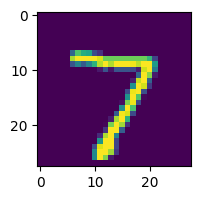

In [6]:
overfit_image = MNIST_TEST[0][0]
plt.figure(figsize=(2,2))
plt.imshow(overfit_image.reshape(28, 28, 1))

In [7]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
losses = []

You can run the following block multiple times to train the same model without restarting:

  0%|          | 0/200 [00:00<?, ?it/s]

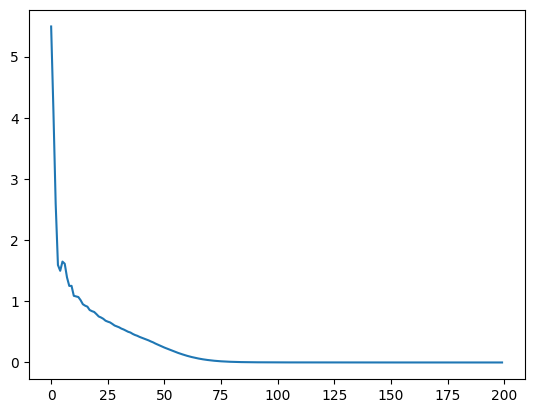

In [8]:
model.train()
for epoch in tqdm(range(200), leave=False):
    train_loss = 0.0
    for img in [overfit_image]:
        # Convert image to a signal with L = 784 and dimension 1
        img = img.to(device).reshape(-1, 784, 1)
        # Shift and pad with zero to generate input
        x = torch.cat([torch.zeros(img.size(0), 1, 1, device=device), img[:, :-1, :]], dim=1)
        # For each sample i, predict the next sample (i+1) from the slice between 0 to i
        y_hat = model(x)
        
        y = torch.mul(img, 255.0).to(torch.int64).to(device)[:,:,0]
        loss = criterion(y_hat.reshape(-1, 256), y.reshape(-1))

        loss_val = loss.detach().cpu().item()
        train_loss += loss_val
        losses.append(loss_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(losses)
plt.show()

## Convolutional Sampling

This one generates each pixel assuming that all previous pixels are predicted correctly, i.e., sample $i$ is predicted from ground truth values of samples $0$ to $i-1$ instead of generated samples.

In [69]:
model.eval()
with torch.no_grad():
    img = overfit_image.to(device).reshape(-1, 784, 1)
    x = torch.cat([torch.zeros(img.size(0), 1, 1, device=device), img[:, :-1, :]], dim=1)
    y_hat = model(x)
    sample = torch.argmax(y_hat, dim=-1)

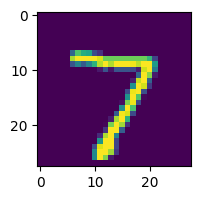

In [70]:
plt.figure(figsize=(2, 2))
plt.imshow(sample.cpu().reshape(28, 28, 1))

## Sampling

The following method will autoregressively sample from the given model `m`. It can optionally use a priming signal to start with. When `maxp` is `True`, it will always choose the value with highest probability instead of random sampling.

In [63]:
def generate_sample(m, priming_signal=None, maxp=False):
    f = m.get_recurrent_runner()
    # The input is padded with 0 at the start
    u = f(torch.zeros(1, 1, device=device))

    # Process the priming signal if given
    if priming_signal is not None:
        for s in priming_signal:
            u = f(s.reshape(1, 1))
        primed_size = priming_signal.size(0)
    else:
        primed_size = 0

    # Generate the new part
    Y = []
    for _ in range(784 - primed_size):
        if maxp:
            p = torch.argmax(u, dim=-1)
        else:
            dist = torch.distributions.categorical.Categorical(probs=torch.nn.functional.softmax(u, dim=-1))
            p = dist.sample()
        p = p.reshape(1, 1) / 255.0
        Y.append(p)
        u = f(p)

    generated = torch.cat(Y, dim=1).real.flatten()
    # Red: generated part
    # Green: given part
    if priming_signal is not None:
        priming_signal = priming_signal.flatten()
        red = torch.cat([torch.zeros_like(priming_signal), generated], dim=0)
        green = torch.cat([priming_signal, torch.zeros_like(generated)], dim=0)
    else:
        red = generated
        green = torch.zeros_like(red)
    blue = torch.zeros_like(green)
    return torch.cat([color.reshape(28, 28, 1) for color in [red, green, blue]], dim=-1)

In [64]:
def overfit_sample(start=0, maxp=False):
    model.eval()
    with torch.no_grad():
        img = overfit_image
        img = img.to(device).reshape(-1, 784, 1)
        sample = generate_sample(model, img[0, :start, :] if start > 0 else None, maxp).cpu()
        plt.figure(figsize=(2,2))
        plt.axis('off')
        plt.imshow(sample)

Let's sample some images.

<b style="color: red;">Red</b> parts are generated, <b style="color: green;">green</b> parts are given in the priming signal.

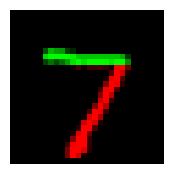

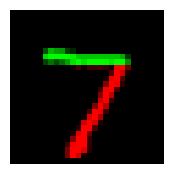

In [67]:
torch.manual_seed(42)
overfit_sample(28*10)
overfit_sample(28*10, maxp=True)

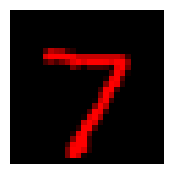

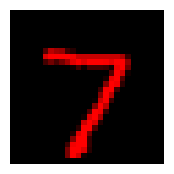

In [68]:
torch.manual_seed(7)
overfit_sample()
overfit_sample()

# Full Dataset

In [71]:
torch.manual_seed(42)

model = SaShiMi(
    input_dim=1,
    hidden_dim=64,
    output_dim=256,
    state_dim=64,
    sequence_length=784,
    block_count=2,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()
losses = []

You can run the following block multiple times to train the same model without restarting:

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 1 loss: 0.7941518191695197


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 2 loss: 0.7467632965842866


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 3 loss: 0.7763504243016268


  0%|          | 0/7500 [00:00<?, ?it/s]

Epoch 4 loss: 0.7242769702951095


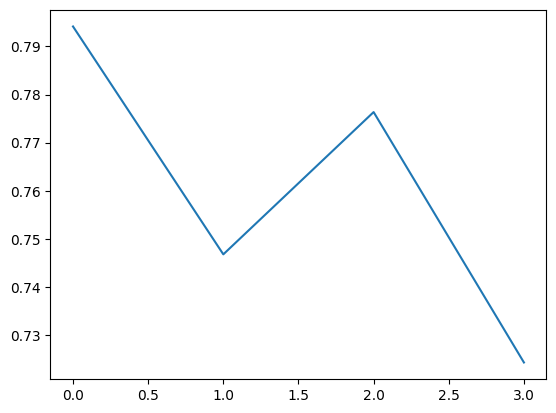

In [72]:
model.train()
for epoch in tqdm(range(4), leave=False):
    train_loss = 0.0
    for img, _ in tqdm(dataloader, leave=False):
        # Convert image to a signal with L = 784 and dimension 1
        img = img.to(device).reshape(-1, 784, 1)
        # Shift and pad with zero to generate input
        x = torch.cat([torch.zeros(img.size(0), 1, 1, device=device), img[:, :-1, :]], dim=1)
        # For each sample i, predict the next sample (i+1) from the slice between 0 to i
        y_hat = model(x)
        
        y = torch.mul(img, 255.0).to(torch.int64).to(device)[:,:,0]
        loss = criterion(y_hat.reshape(-1, 256), y.reshape(-1))

        loss_val = loss.detach().cpu().item()
        train_loss += loss_val / len(dataloader)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(train_loss)
    print(f"Epoch {len(losses)} loss: {train_loss}")

plt.plot(losses)
plt.show()

In [73]:
def image_sample(img=None, start=0, maxp=False):
    model.eval()
    with torch.no_grad():
        if img is not None and start > 0:
            img = img.to(device).reshape(-1, 784, 1)[0, :start, :]
        sample = generate_sample(model, img, maxp).cpu()
        plt.figure(figsize=(2,2))
        plt.axis('off')
        plt.imshow(sample)

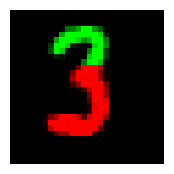

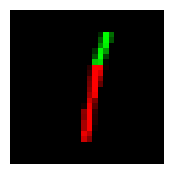

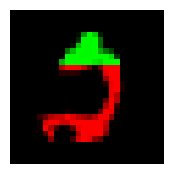

In [74]:
torch.manual_seed(42)
image_sample(MNIST_TEST[1][0], 28*10)
image_sample(MNIST_TEST[2][0], 28*10)
image_sample(MNIST_TEST[3][0], 28*10)

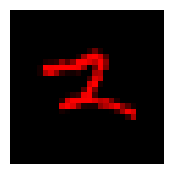

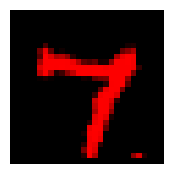

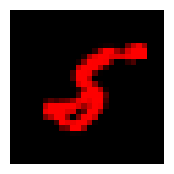

In [83]:
torch.manual_seed(0)
image_sample()
image_sample()
image_sample()

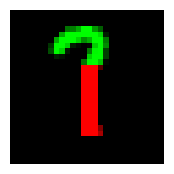

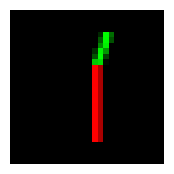

In [80]:
image_sample(MNIST_TEST[1][0], 28*10, maxp=True)
image_sample(MNIST_TEST[2][0], 28*10, maxp=True)

### Saving & Loading the Model

In [81]:
torch.save(model, "./models/sashimi-mnist.pt")

In [82]:
model = torch.load("./models/sashimi-mnist.pt")

# NLL

Here, we compute the average negative log likelihood (NLL) value on the test dataset.

Note that [CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) simply calculates the NLL by applying softmax internally:

$$
l_n = - \log \frac{\exp(x_{n,y_n})}{\sum_{c=1}^C \exp(x_{n,c})}
$$

PyTorch uses natural log by default. We convert this to NLL in bits by dividing the result by $\log(2)$. 

In [84]:
model.eval()
criterion = torch.nn.CrossEntropyLoss()
with torch.no_grad():
    nll = 0.0
    for img, _ in tqdm(testloader, leave=False):
        # Convert image to a signal with L = 784 and dimension 1
        img = img.to(device).reshape(-1, 784, 1)
        # Shift and pad with zero to generate input
        x = torch.cat([torch.zeros(img.size(0), 1, 1, device=device), img[:, :-1, :]], dim=1)
        y = torch.mul(img, 255.0).to(torch.int64).to(device)[:,:,0]
        # For each sample i, predict the next sample (i+1) from the slice between 0 to i
        y_hat = model(x)
        nll += criterion(y_hat.reshape(-1, 256), y.reshape(-1))
    nll /= len(MNIST_TEST)

    print("Average NLL:", nll.item())
    print("Average NLL in base 2:", (nll / torch.tensor(2.0).log()).item())
    print("Average NLL converted to probability:", (-nll).exp().item())

  0%|          | 0/10000 [00:00<?, ?it/s]

Average NLL: 0.7191216349601746
Average NLL in base 2: 1.037473201751709
Average NLL converted to probability: 0.4871799945831299


The result is worse than `S4-MNIST-Demo`. That's probably because SaShiMi is larger than vanilla S4 and hence requires more training